In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cft
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import rc
rc('animation', html='html5')

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

We use parallel processing to make our computations faster. For this, we do the following:

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:45747 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
import cosima_cookbook as cc
session = cc.database.create_session()

In [4]:
db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_total.db'
session = cc.database.create_session(db)
expt = ['025deg_jra55_ryf_nostress_cont','025deg_jra55_ryf_nostress']
names = {'025deg_jra55_ryf_nostress_cont':'Control','025deg_jra55_ryf_nostress':'No Stress'}

In [6]:
#Searching variables
vars_025deg = cc.querying.get_variables(session, experiment= expt[1])
vars_025deg[vars_025deg['name'].str.lower().str.match('pme_river')]

,name,long_name,frequency,ncfile,# ncfiles,time_start,time_end
162,pme_river,mass flux of precip-evap+river via sbc (liquid...,1 daily,output027/ocean/ocean-2d-pme_river-1-daily-mea...,38,1914-01-01 00:00:00,1956-01-01 00:00:00
309,pme_river,mass flux of precip-evap+river via sbc (liquid...,1 monthly,output027/ocean/ocean-2d-pme_river-1-monthly-m...,56,1900-01-01 00:00:00,1956-01-01 00:00:00


### What is happening to the salinity?

In [9]:
salt_global_con = cc.querying.getvar(expt[0],'salt_global_ave',session,start_time='1901-01-01',end_time = '1950-12-31')
salt_global_buo = cc.querying.getvar(expt[1],'salt_global_ave',session,start_time='1901-01-01',end_time = '1950-12-31')

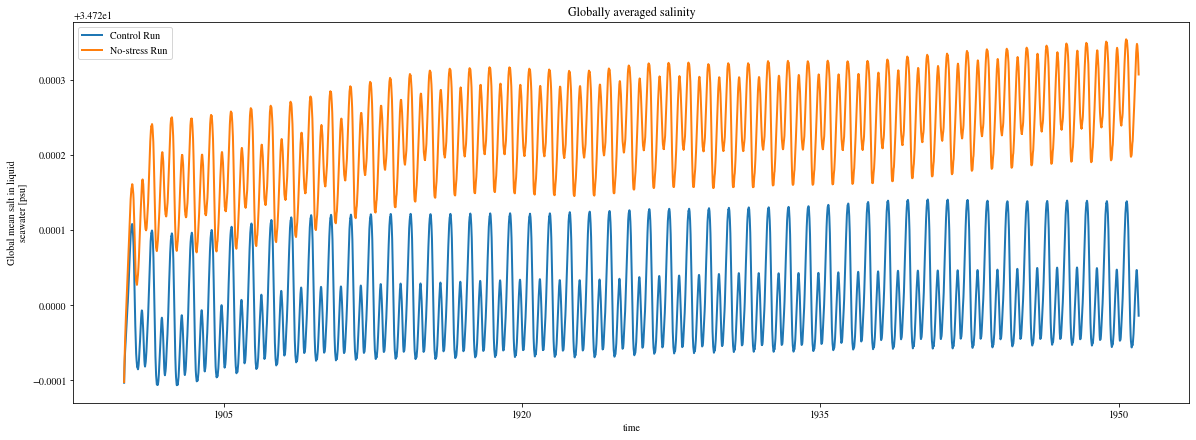

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(111)
salt_global_con.plot()
salt_global_buo.plot()
plt.title('Globally averaged salinity')
plt.legend(['Control Run','No-stress Run']) 
plt.show()

It looks like the global salinity in the ocean is almost staying constant. This is good news as this implies that the salinity restoring is in place, and the total salt in the oceans is conserved, which should be true. Let's see how the surface salinity is varying with time.

In [15]:
salt_sfc_con = cc.querying.getvar(expt[0],'salt_surface_ave',session,start_time='1901-01-01',end_time = '1950-12-31')
salt_sfc_buo = cc.querying.getvar(expt[1],'salt_surface_ave',session,start_time='1901-01-01',end_time = '1950-12-31')

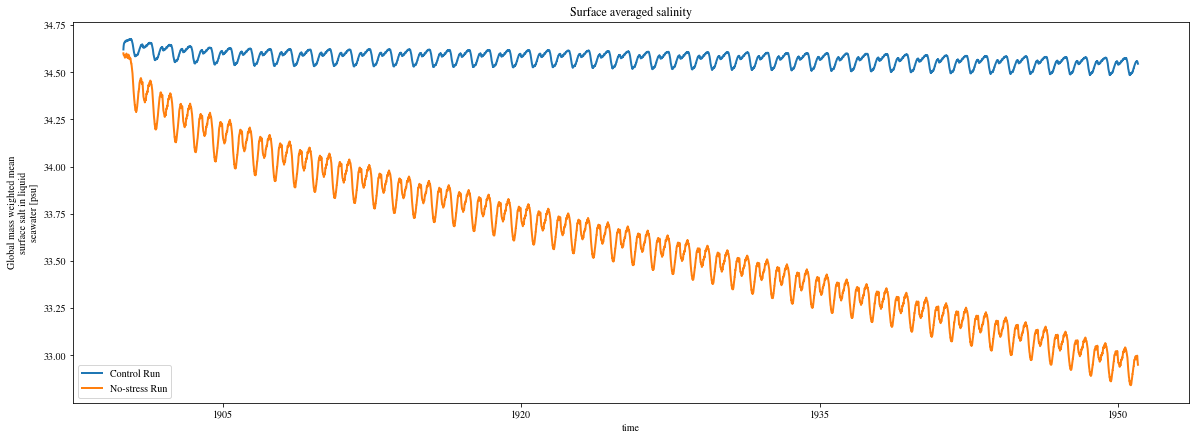

In [16]:
plt.figure(figsize=(20,7))
plt.subplot(111)
salt_sfc_con.plot()
salt_sfc_buo.plot()
plt.title('Surface averaged salinity')
plt.legend(['Control Run','No-stress Run']) 
plt.show()

To our surprise, there are huge differences in salinity between the control and no-stress run at the surface, as witnessed above. We first plot a number of contour plots at different depths for salintiy in the North Atlantic Ocean, and compare the two runs for 1900-1901 and 1949-1950, and then state our hypthesis. Alternatively, there are animation plots for monthwise and yearwise surface salinity differences (between the control and buoyancy run) in the github repository too.

In [27]:
x_min = -90
x_max = 10
y_min = 10
y_max = 65
salt_con_1950 = cc.querying.getvar(expt[0],'salt',session,start_time='1949-01-01',end_time = '1950-12-31')#.sel(
#    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))#.sel(st_ocean = 3.5, method = 'nearest')
salt_buo_1950 = cc.querying.getvar(expt[1],'salt',session,start_time='1949-01-01',end_time = '1950-12-31')#.sel(
#    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))#.sel(st_ocean = 3.5, method = 'nearest')

Text(0.5, 1.0, 'Salinity Difference - st_ocean = 5000')

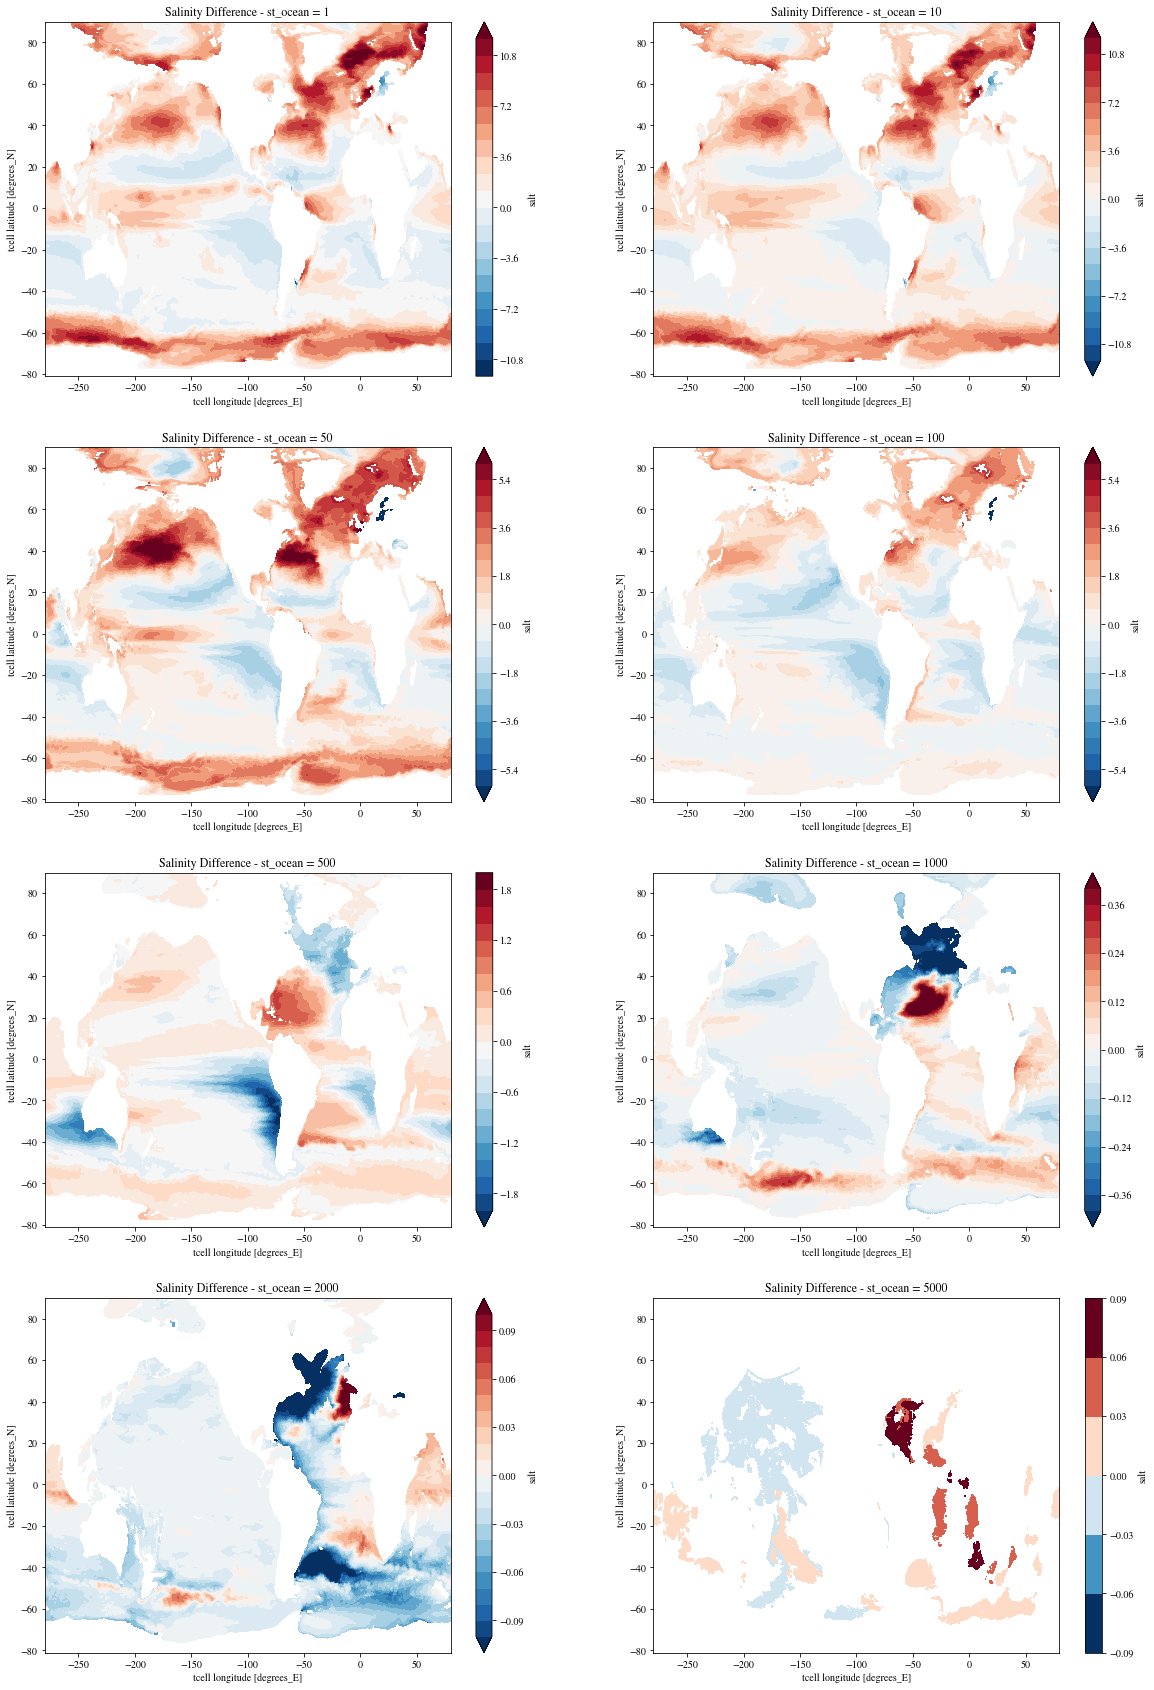

In [6]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(20,30))

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 1, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[0][0],levels = np.linspace(-12,12,21))
axes[0][0].set_title('Salinity Difference - st_ocean = 1')

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 10, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[0][1],levels = np.linspace(-12,12,21))
axes[0][1].set_title('Salinity Difference - st_ocean = 10')

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 50, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[1][0],levels = np.linspace(-6,6,21))
axes[1][0].set_title('Salinity Difference - st_ocean = 50')

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 100, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[1][1],levels = np.linspace(-6,6,21))
axes[1][1].set_title('Salinity Difference - st_ocean = 100')

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 500, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[2][0],levels = np.linspace(-2,2,21))
axes[2][0].set_title('Salinity Difference - st_ocean = 500')

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 1000, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[2][1],levels = np.linspace(-0.4,0.4,21))
axes[2][1].set_title('Salinity Difference - st_ocean = 1000')

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 2000, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[3][0],levels = np.linspace(-0.1,0.1,21))
axes[3][0].set_title('Salinity Difference - st_ocean = 2000')

(salt_con_1950 - salt_buo_1950).sel(st_ocean = 5000, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(ax = axes[3][1])
axes[3][1].set_title('Salinity Difference - st_ocean = 5000')

In [7]:
salt_con_1901 = cc.querying.getvar(expt[0],'salt',session,start_time='1900-01-01',end_time = '1901-12-31')#.sel(
#    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))#.sel(st_ocean = 3.5, method = 'nearest')
salt_buo_1901 = cc.querying.getvar(expt[1],'salt',session,start_time='1900-01-01',end_time = '1901-12-31')#.sel(
#    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))#.sel(st_ocean = 3.5, method = 'nearest')

Text(0.5, 1.0, 'Salinity Difference - st_ocean = 1000')

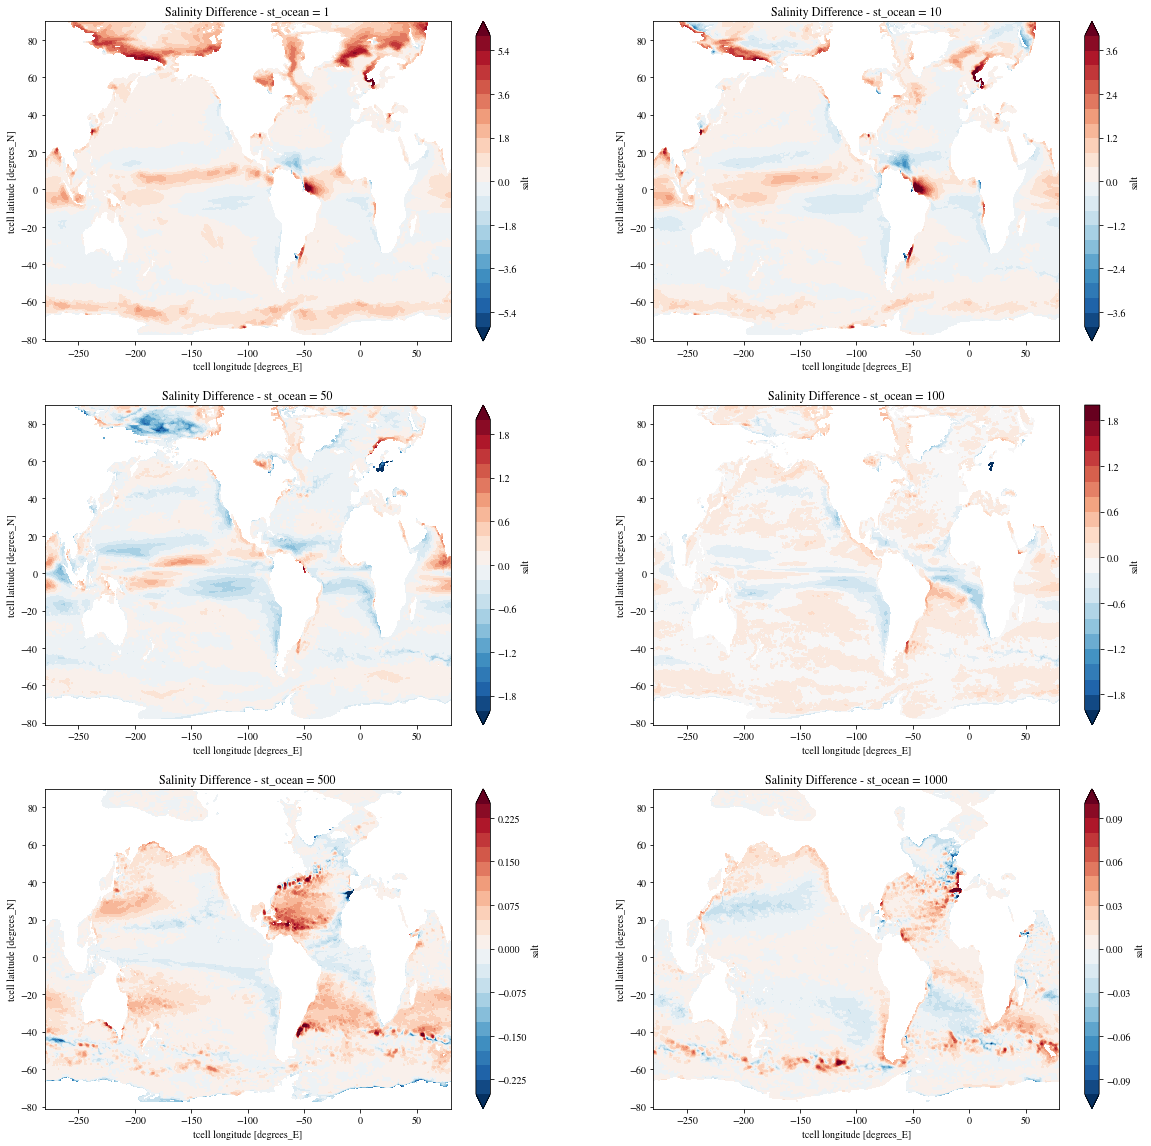

In [8]:
fig, axes = plt.subplots(nrows=3,ncols=2,figsize=(20,20))

(salt_con_1901 - salt_buo_1901).sel(st_ocean = 1, method = 'nearest').sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(ax = axes[0][0],levels = np.linspace(-6,6,21))
axes[0][0].set_title('Salinity Difference - st_ocean = 1')

(salt_con_1901 - salt_buo_1901).sel(st_ocean = 10, method = 'nearest').sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(ax = axes[0][1],levels = np.linspace(-4,4,21))
axes[0][1].set_title('Salinity Difference - st_ocean = 10')

(salt_con_1901 - salt_buo_1901).sel(st_ocean = 50, method = 'nearest').sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(ax = axes[1][0],levels = np.linspace(-2,2,21))
axes[1][0].set_title('Salinity Difference - st_ocean = 50')

(salt_con_1901 - salt_buo_1901).sel(st_ocean = 100, method = 'nearest').sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(ax = axes[1][1],levels = np.linspace(-2,2,21))
axes[1][1].set_title('Salinity Difference - st_ocean = 100')

(salt_con_1901 - salt_buo_1901).sel(st_ocean = 500, method = 'nearest').sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(ax = axes[2][0],levels = np.linspace(-0.25,0.25,21))
axes[2][0].set_title('Salinity Difference - st_ocean = 500')

(salt_con_1901 - salt_buo_1901).sel(st_ocean = 1000, method = 'nearest').sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(ax = axes[2][1],levels = np.linspace(-0.1,0.1,21))
axes[2][1].set_title('Salinity Difference - st_ocean = 1000')

In [5]:
salt_con = cc.querying.getvar(expt[0],'salt',session,start_time='1900-01-01',end_time = '1905-12-31').sel(st_ocean = 0, method = 'nearest')#.sel(
#    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))#.sel(st_ocean = 3.5, method = 'nearest')
salt_buo = cc.querying.getvar(expt[0],'salt',session,start_time='1900-01-01',end_time = '1905-12-31').sel(st_ocean = 0, method = 'nearest')#.sel(
#    xt_ocean = slice(x_min,x_max)).sel(yt_ocean = slice(y_min,y_max))#.sel(st_ocean = 3.5, method = 'nearest')

To condense this into a simple figure, we have an animated plot for the surface salinity in the ocean from year 1900 till year 1950, which qualititatively shows how the surface salinity is varying at different locations temporally.

The global salinity data leads us to belive that since the total salt in the ocean stays constant. So, if the control run is more saline near the surface, the no-stress run is expected to be more saline in the lower depths. Although our hypothesis seems correct to an extent, it is not entirely visible in the graphs. If this is the case, where does the extra salt go?

The next step is to plot the differences in freshwater fluxes for the control and buoyancy run, with positive values signifying that there is a freshwater input in the ocean in that location, which should theoretically imply that the ocean should be less saline in that region between the two cases considered.

In [48]:
pme_net_con = cc.querying.getvar(expt[0],'pme_net',session,start_time='1900-01-01',end_time = '1901-12-31')
pme_net_buo = cc.querying.getvar(expt[1],'pme_net',session,start_time='1900-01-01',end_time = '1901-12-31')

Text(0.5, 1.0, 'Salinity Difference - st_ocean = 1')

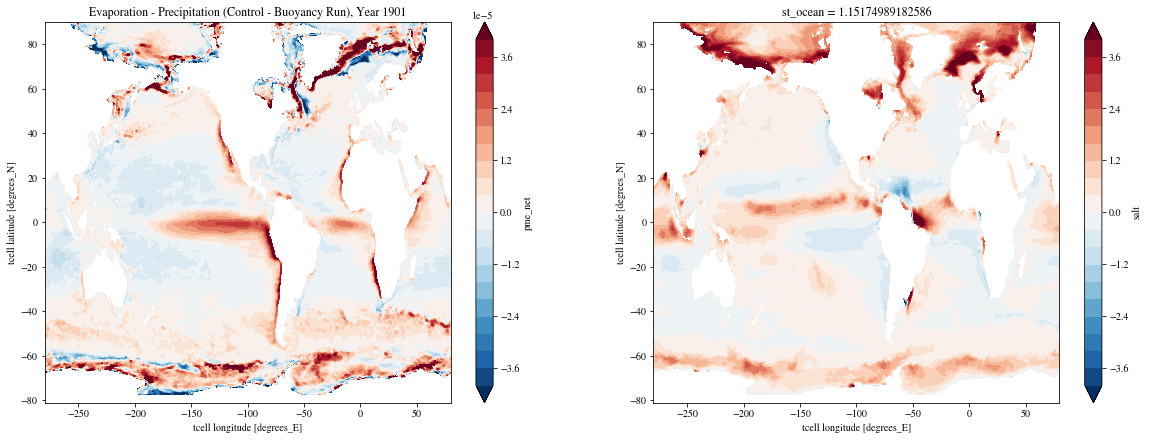

In [49]:
plt.figure(figsize=(20,7))
plt.subplot(121)
(pme_net_con - pme_net_buo).sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(levels = np.linspace(-4e-5,4e-5,21))
plt.title('Freshwater input (Control - Buoyancy Run), Year 1901')

plt.subplot(122)
(salt_con_1901-salt_buo_1901).sel(st_ocean = 1, method = 'nearest').sel(time = slice('1900-01-01','1901-12-31')).mean('time').plot.contourf(levels = np.linspace(-4,4,21))
axes[0][0].set_title('Salinity Difference - st_ocean = 1')

In [50]:
pme_net_con_1950 = cc.querying.getvar(expt[0],'pme_net',session,start_time='1949-01-01',end_time = '1950-12-31',frequency = '1 monthly')
pme_net_buo_1950 = cc.querying.getvar(expt[1],'pme_net',session,start_time='1949-01-01',end_time = '1950-12-31',frequency = '1 monthly')

Text(0.5, 1.0, 'Salinity Difference - st_ocean = 1')

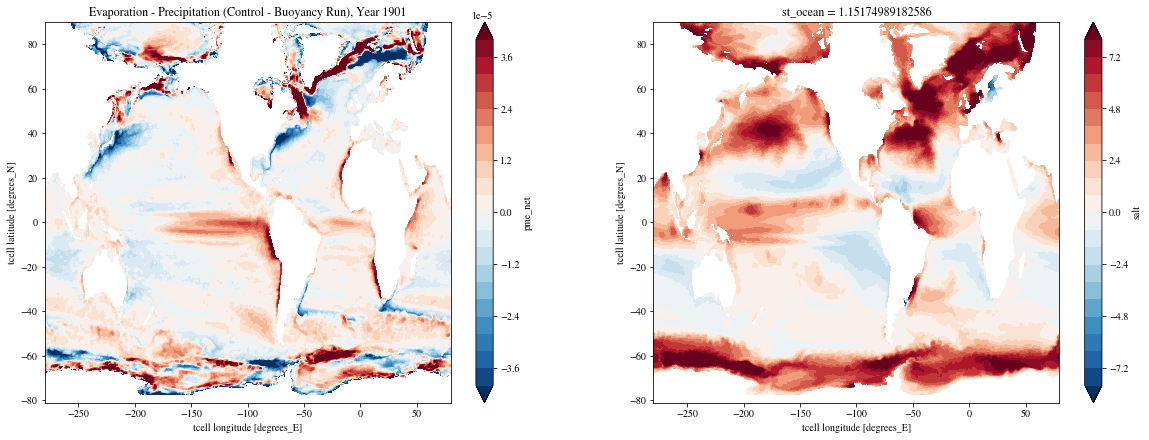

In [51]:
plt.figure(figsize=(20,7))
plt.subplot(121)
(pme_net_con_1950 - pme_net_buo_1950).sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-4e-5,4e-5,21))
plt.title('Freshwater input (Control - Buoyancy Run), Year 1901')

plt.subplot(122)
(salt_con_1950-salt_buo_1950).sel(st_ocean = 1, method = 'nearest').sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-8,8,21))
axes[0][0].set_title('Salinity Difference - st_ocean = 1')

## What next?

The previous exercise showed us that there are huge differences in salinity between the control and buoyancy run. It is also visible that the control run is more salty in the upper ocean (till about 1 km) and then becomes fresher with respect to the buoyancy run. We look at the sea ice cover in different regions now, although, the reader can skip this part since it didn't lead to any conclusions.

In [68]:
variable='aice_m'
aice_con = cc.querying.getvar(expt[0], variable, session, frequency='1 monthly', start_time='1949-01-01', end_time='1950-12-31',decode_coords=False)
aice_buo = cc.querying.getvar(expt[1], variable, session, frequency='1 monthly', start_time='1949-01-01', end_time='1950-12-31',decode_coords=False)
area_t = cc.querying.getvar(expt='025deg_jra55_ryf_nostress', variable='area_t', session=session, frequency='static', n=1)

aice_con.coords['ni'] = area_t['xt_ocean'].values
aice_con.coords['nj'] = area_t['yt_ocean'].values
aice_con = aice_con.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

aice_buo.coords['ni'] = area_t['xt_ocean'].values
aice_buo.coords['nj'] = area_t['yt_ocean'].values
aice_buo = aice_buo.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

area_con = aice_con*area_t
area_buo = aice_buo*area_t

In [71]:
## Arctic Region

In [29]:
wfiform_con = cc.querying.getvar(expt[0],'wfiform',session,start_time='1900-01-01',end_time = '1950-12-31')
wfiform_buo = cc.querying.getvar(expt[1],'wfiform',session,start_time='1900-01-01',end_time = '1950-12-31')

In [28]:
wfimelt_con = cc.querying.getvar(expt[0],'wfimelt',session,start_time='1900-01-01',end_time = '1950-12-31')
wfimelt_buo = cc.querying.getvar(expt[1],'wfimelt',session,start_time='1900-01-01',end_time = '1950-12-31')

In [34]:
area_t = cc.querying.getvar(expt=expt[0], variable='area_t', session=session, frequency='static', n=1)#.sel(
#    xt_ocean = slice(-60,40)).sel(yt_ocean = slice(55,80))
wfimelt_avg_con = (wfimelt_con*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
wfimelt_avg_buo = (wfimelt_buo*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])

In [37]:
wfiform_avg_con = (wfimelt_con*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
wfiform_avg_buo = (wfimelt_buo*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])

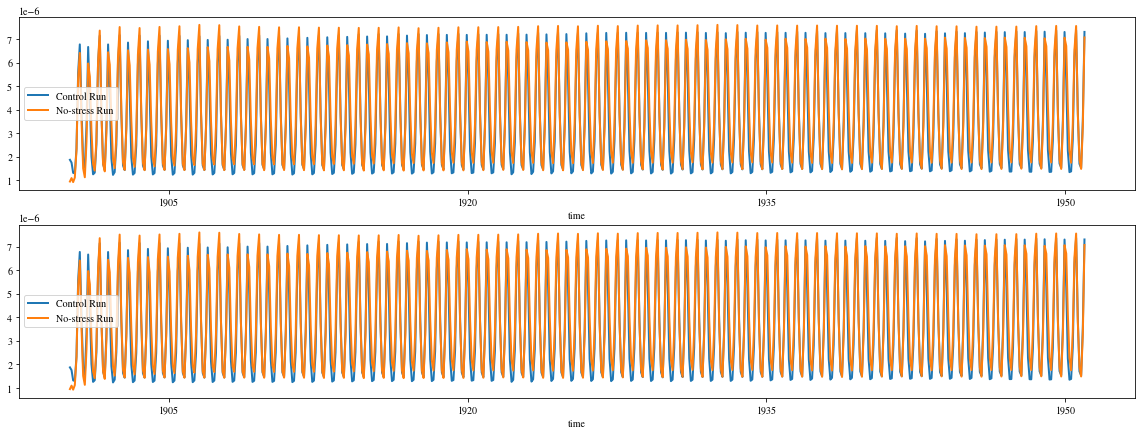

In [38]:
plt.figure(figsize = (20,14))

plt.subplot(211)
wfimelt_avg_con.plot()
wfimelt_avg_buo.plot()
plt.title('Time series of sea icea melting')
plt.legend(['Control Run','No-stress Run']) 

plt.subplot(212)
wfiform_avg_con.plot()
wfiform_avg_buo.plot()
plt.title('Time series of se ice formation')
plt.legend(['Control Run','No-stress Run']) 

plt.show()

We hypothesise that the reason behind the surface salinity in the control run being much more than the buoyancy run is due to the breaking down of the upper cell of the MOC. The MOC has an upper and lower cell, and when there is upwelling in the Southern Ocean, water mass transformation occurs, leading to both fresher and saltier water masses. If the water mass transformation fails for the upper cell, more and more salt will go away from the upper ocean and be sent off to greater depths via the lower MOC cell. 

To confirm this hypothesis, we plot the meridional overturning circulation for the two cases. We observe a lack of an upper cell, and a diminished (?) lower cell, although it does exist.

In [17]:
psi_con = cc.querying.getvar(expt[0],'ty_trans_rho',session,start_time = '1900-01-01',end_time = '1901-12-31')
psi_con = psi_con.sum('grid_xt_ocean')
rho = 1025 # mean density of sea-water in kg/m^3
psi_con = psi_con / (1e6*rho) # converts kg/s to Sv
psi_avg_con = psi_con.cumsum('potrho').mean('time') - psi_con.sum('potrho').mean('time')

psi_buo = cc.querying.getvar(expt[1],'ty_trans_rho',session,start_time = '1900-01-01',end_time = '1901-12-31')
psi_buo = psi_buo.sum('grid_xt_ocean')
rho = 1025 # mean density of sea-water in kg/m^3
psi_buo = psi_buo / (1e6*rho) # converts kg/s to Sv
psi_avg_buo = psi_buo.cumsum('potrho').mean('time') - psi_buo.sum('potrho').mean('time')

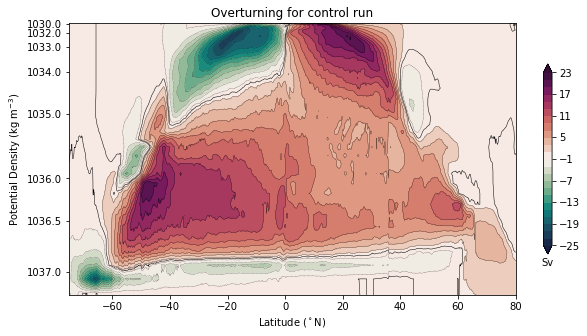

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf(psi_avg_con.grid_yu_ocean,(psi_avg_con.potrho-1028)**scfac, psi_avg_con, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
ax.contour(psi_avg_con.grid_yu_ocean,(psi_avg_con.potrho-1028)**scfac, psi_avg_con, levels=clev, colors='k', linewidths=0.25)
ax.contour(psi_avg_con.grid_yu_ocean,(psi_avg_con.potrho-1028)**scfac, psi_avg_con, levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Overturning for control run');

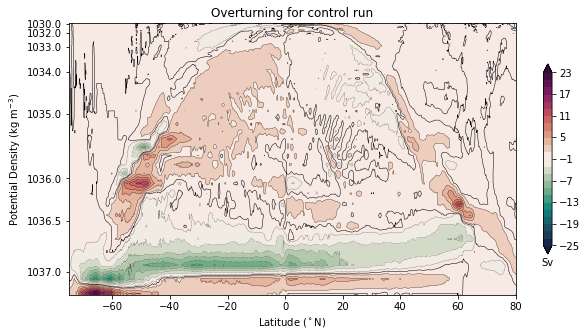

In [21]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf(psi_con.grid_yu_ocean,(psi_con.potrho-1028)**scfac, psi_con.mean('time'), cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
ax.contour(psi_con.grid_yu_ocean,(psi_con.potrho-1028)**scfac, psi_con.mean('time'), levels=clev, colors='k', linewidths=0.25)
ax.contour(psi_con.grid_yu_ocean,(psi_con.potrho-1028)**scfac, psi_con.mean('time'), levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Overturning for control run');

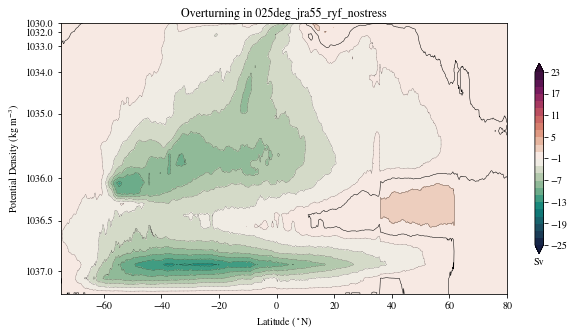

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10, 5)) 
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
p1=ax.contourf(psi_avg_buo.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
ax.contour(psi_avg_buo.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, levels=clev, colors='k', linewidths=0.25)
ax.contour(psi_avg_buo.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, levels=[0.0,], colors='k', linewidths=0.5)

ax.set_yticks((yticks-1028)**scfac)
ax.set_yticklabels(yticks)
ax.set_ylim([0.5**scfac, 9.2**scfac])
ax.invert_yaxis()
ax.set_ylabel('Potential Density (kg m$^{-3}$)')
ax.set_xlabel('Latitude ($^\circ$N)')
ax.set_xlim([-75,80])
ax.set_title('Overturning in %s' % expt[1]);

In [ ]:
psi_con = cc.querying.getvar(expt[0],'ty_trans_int_z',session,start_time = '1949-01-01',end_time = '1950-12-31')
psi_con = psi_con.sum('xt_ocean')
rho = 1025 # mean density of sea-water in kg/m^3
psi_con = psi_con / (1e6*rho) # converts kg/s to Sv
psi_avg_con = psi_con.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')

psi_buo = cc.querying.getvar(expt[1],'ty_trans_rho',session,start_time = '1949-01-01',end_time = '1950-12-31')
psi_buo = psi_buo.sum('grid_xt_ocean')
rho = 1025 # mean density of sea-water in kg/m^3
psi_buo = psi_buo / (1e6*rho) # converts kg/s to Sv
psi_avg_buo = psi_buo.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')

## Animation for MOC

For convenience, we have created an animation for the MOC for both the control and no stress experiments, and it is clearly seen that the strength of the upper cell reduces drastically.

In [ ]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cft
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import rc
rc('animation', html='html5')

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

import netCDF4 as nc
import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [5]:
dir = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress/output000/ocean'
file = os.path.join(dir,'ocean-3d-ty_trans_rho-1-monthly-mean-ym_1900_01.nc')

In [6]:
data = xr.open_dataset(file)
filename = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress/output000/ocean/ocean-3d-ty_trans_rho-1-monthly-mean-ym_1900_01.nc'
particles = nc.Dataset(filename)
y = particles.variables['potrho'][:] 
x = particles.variables['grid_yu_ocean'][:]
time1 = particles.variables['time'][:]

In [7]:
X,Y = np.meshgrid(x,y)

In [10]:
rho = 1025
psi_buo = ((data.ty_trans_rho.sum('grid_xt_ocean'))/(1e6*rho))
psi_avg_buo = psi_buo.cumsum('potrho').mean('time') - psi_buo.sum('potrho').mean('time')

In [22]:
fig = plt.figure(figsize=(10, 5)) 
clev = np.arange(-25,25,2)

yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
#p1 = plt.pcolormesh(X, (Y - 1028)**scfac, psi, shading = 'auto', cmap = cm.cm.curl)
p1 = plt.contourf(psi_avg_buo.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, cmap=cm.cm.curl, levels=clev, extend='both')
cb = plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, levels=[0.0,], colors='k', linewidths=0.5)

plt.yticks((yticks-1028)**scfac,yticks)
plt.ylim([0.5**scfac, 9.2**scfac])
plt.gca().invert_yaxis()
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Year 1900')
#ax.set_title('Overturning circulation');

TypeError: cannot unpack non-iterable Figure object

<Figure size 720x360 with 0 Axes>

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


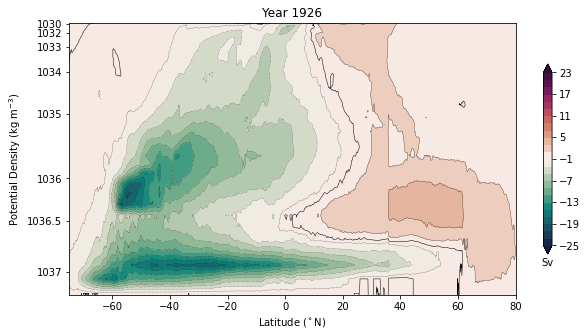

In [23]:
#Year averaged MOC animation

nframes = 27
startframe = 1
nt = 1

fig = plt.figure(figsize=(10, 5))
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set the stretching
rho = 1025

def updatefig(nt):
    plt.clf()
    currentframe = startframe + nt
    year = 1900 + nt
    month = nt%12
    
    iter1 = 'ocean-3d-ty_trans_rho-1-monthly-mean-ym_%4d_01.nc' % (year)
    #iter2 = 'ocean-3d-ty_trans_rho-1-monthly-mean-ym_%4d_01.nc' % (year)

    d = np.floor((year - 1900)/2)
    if d <= 9:
        dir1 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress/output00%d/ocean' % d
    #    dir2 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_cont/output00%d/ocean' % d
    else:
        dir1 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress/output0%d/ocean' % d
    #    dir2 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_cont/output0%d/ocean' % d

    file1 = os.path.join(dir1,iter1)
    #file2 = os.path.join(dir2,iter2)

    data1 = xr.open_dataset(file1)
    #data2 = xr.open_dataset(file2)
    
    psi_buo = ((data1.ty_trans_rho.sum('grid_xt_ocean'))/(1e6*rho))
    psi_avg_buo = psi_buo.cumsum('potrho').mean('time') - psi_buo.sum('potrho').mean('time')
    
    plt.title('Year %4d' % year)
    p1 = plt.contourf(psi_avg_buo.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, cmap=cm.cm.curl, levels=clev, extend='both')
    cb = plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg_buo.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg_buo.grid_yu_ocean,(psi_avg_buo.potrho-1028)**scfac, psi_avg_buo, levels=[0.0,], colors='k', linewidths=0.5)
    plt.yticks((yticks-1028)**scfac,[1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
    #plt.yticklabels(yticks)
    plt.ylim([0.5**scfac, 9.2**scfac])
    plt.gca().invert_yaxis()
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,80])
    #plt.title('Year %4d' % year)

    filestr = '/home/156/db6174/x77/Test_Notebooks/Salinity_Buoyancy_Fig/MOC_nostress/image%04d.png' % nt
    plt.savefig(filestr,dpi=900)
    print(nt)        
    return p1
    
anim = animation.FuncAnimation(fig, updatefig, frames=nframes, interval=1, blit=False)
metadata = dict(title='MOC_Yearly', artist='GFD ANU',comment='Animation made using matplotlib and ffmpeg')
ffwriter = animation.FFMpegWriter(fps=2, codec='libx264', bitrate=4000, extra_args=['-pix_fmt','yuv420p'], metadata=metadata)
anim.save('MOC_nostress.m4v', writer=ffwriter)

plt.show()

## Control Run

In [24]:
dir = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_cont/output000/ocean'
file = os.path.join(dir,'ocean-3d-ty_trans_rho-1-monthly-mean-ym_1900_01.nc')

In [29]:
data = xr.open_dataset(file)
filename = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_cont/output000/ocean/ocean-3d-ty_trans_rho-1-monthly-mean-ym_1900_01.nc'
particles = nc.Dataset(filename)
y = particles.variables['potrho'][:] 
x = particles.variables['grid_yu_ocean'][:]
time1 = particles.variables['time'][:]

In [26]:
rho = 1025
psi = ((data.ty_trans_rho.sum('grid_xt_ocean'))/(1e6*rho)).mean('time')

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


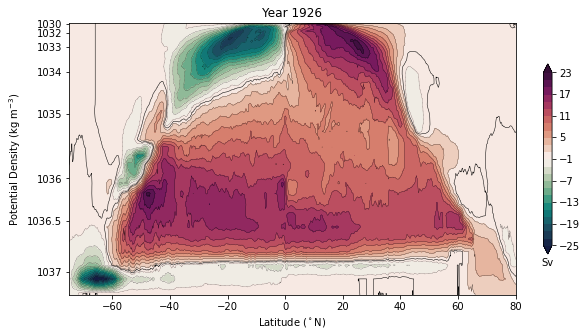

In [31]:
#Year averaged MOC animation

nframes = 27
startframe = 1
nt = 1

fig = plt.figure(figsize=(10, 5))
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set the stretching
rho = 1025

def updatefig(nt):
    plt.clf()
    currentframe = startframe + nt
    year = 1900 + nt
    month = nt%12
    
    #iter1 = 'ocean-3d-ty_trans_rho-1-monthly-mean-ym_%4d_01.nc' % (year)
    iter2 = 'ocean-3d-ty_trans_rho-1-monthly-mean-ym_%4d_01.nc' % (year)

    d = np.floor((year - 1900)/2)
    if d <= 9:
    #    dir1 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress/output00%d/ocean' % d
        dir2 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_cont/output00%d/ocean' % d
    else:
    #    dir1 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress/output0%d/ocean' % d
        dir2 = '/scratch/x77/db6174/access-om2/archive/025deg_jra55_ryf_nostress_cont/output0%d/ocean' % d

    #file1 = os.path.join(dir1,iter1)
    file2 = os.path.join(dir2,iter2)

    #data1 = xr.open_dataset(file1)
    data2 = xr.open_dataset(file2)
    
    psi_con = ((data2.ty_trans_rho.sum('grid_xt_ocean'))/(1e6*rho))
    psi_avg_con = psi_con.cumsum('potrho').mean('time') - psi_con.sum('potrho').mean('time')
    
    p1 = plt.contourf(psi_avg_con.grid_yu_ocean,(psi_avg_con.potrho-1028)**scfac, psi_avg_con, cmap=cm.cm.curl, levels=clev, extend='both')
    cb = plt.colorbar(p1,orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi_avg_con.grid_yu_ocean,(psi_avg_con.potrho-1028)**scfac, psi_avg_con, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg_con.grid_yu_ocean,(psi_avg_con.potrho-1028)**scfac, psi_avg_con, levels=[0.0,], colors='k', linewidths=0.5)
    plt.yticks((yticks-1028)**scfac,[1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
    #plt.yticklabels(yticks)
    plt.ylim([0.5**scfac, 9.2**scfac])
    plt.gca().invert_yaxis()
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,80])
    plt.title('Year %4d' % year)

    filestr = '/home/156/db6174/x77/Test_Notebooks/Salinity_Buoyancy_Fig/MOC_nostress_cont/image%04d.png' % nt
    plt.savefig(filestr,dpi=600)
    print(nt)        
    return p1
    
anim = animation.FuncAnimation(fig, updatefig, frames=nframes, interval=1, blit=False)
metadata = dict(title='MOC_Yearly_control', artist='GFD ANU',comment='Animation made using matplotlib and ffmpeg')
ffwriter = animation.FFMpegWriter(fps=2, codec='libx264', bitrate=4000, extra_args=['-pix_fmt','yuv420p'], metadata=metadata)
anim.save('MOC_nostress_cont.m4v', writer=ffwriter)

plt.show()

## Freshwater fluxes

In [8]:
pme_river_con = cc.querying.getvar(expt[0],'pme_river',session,frequency = '1 monthly', start_time='1901-01-01',end_time = '1950-12-31')
pme_river_buo = cc.querying.getvar(expt[1],'pme_river',session,frequency = '1 monthly', start_time='1901-01-01',end_time = '1950-12-31')

Text(0.5, 1.0, 'Freshwater input - Buoyancy Run')

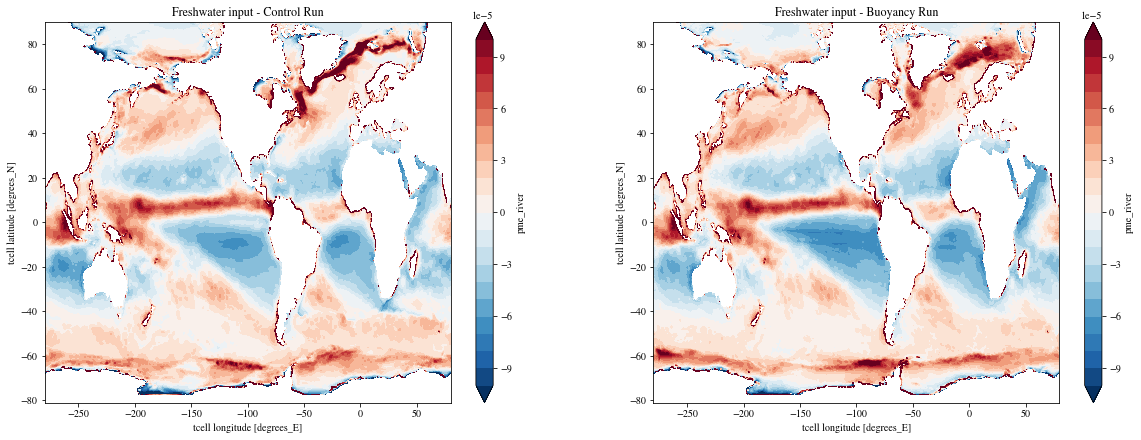

In [18]:
plt.figure(figsize=(20,7))
plt.subplot(121)
pme_river_con.sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-1e-4,1e-4,21))
plt.title('Freshwater input - Control Run')

plt.subplot(122)
pme_river_buo.sel(time = slice('1949-01-01','1950-12-31')).mean('time').plot.contourf(levels = np.linspace(-1e-4,1e-4,21))
plt.title('Freshwater input - Buoyancy Run')
#axes[0][0].set_title('Salinity Difference - st_ocean = 1')

## KPP Boundary Layer

In [9]:
hblt_con = cc.querying.getvar(expt[0],'hblt',session,frequency = '1 monthly', start_time='1901-01-01',end_time = '1950-12-31')
hblt_buo = cc.querying.getvar(expt[1],'hblt',session,frequency = '1 monthly', start_time='1901-01-01',end_time = '1950-12-31')

Text(0.5, 1.0, 'Freshwater input - Buoyancy Run')

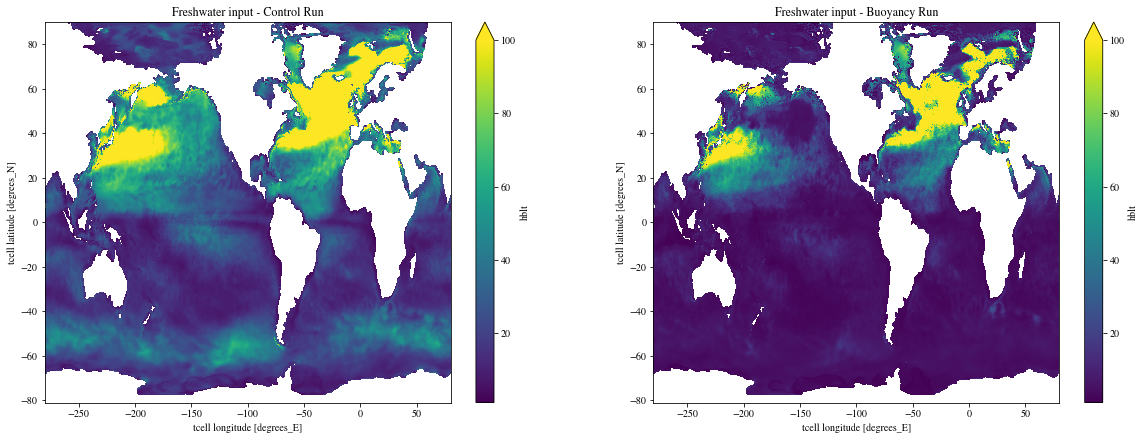

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(121)
hblt_con.sel(time = slice('1900-01-01','1900-01-31')).mean('time').plot(vmax = 100)
plt.title('Freshwater input - Control Run')

plt.subplot(122)
hblt_buo.sel(time = slice('1900-01-01','1900-01-31')).mean('time').plot(vmax = 100)
plt.title('Freshwater input - Buoyancy Run')
#axes[0][0].set_title('Salinity Difference - st_ocean = 1')

## KPP Diffusivity

In [6]:
diff_cbt_con = cc.querying.getvar(expt[0],'diff_cbt_t',session,frequency = '1 monthly', start_time='1900-01-01',end_time = '1950-12-31')
diff_cbt_buo = cc.querying.getvar(expt[1],'diff_cbt_t',session,frequency = '1 monthly', start_time='1900-01-01',end_time = '1950-12-31')

Text(0, 0.5, 'log(depth)')

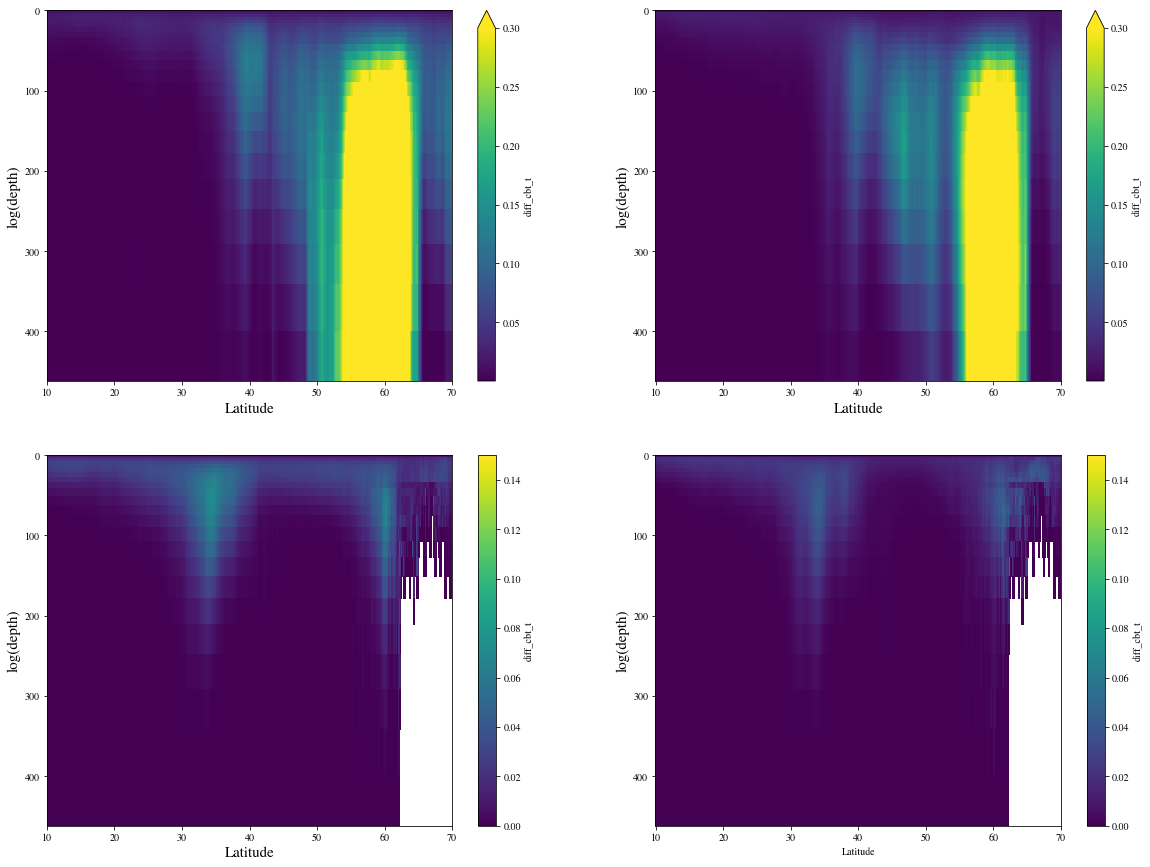

In [10]:
#Atlantic Ocean - Top two
#Pacific Ocean - Bottom two

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,15))

#plt.gca().invert_yaxis()
#axes[0][0].set_yscale("log")
diff_cbt_con.sel(st_ocean = slice(0,500)).sel(xt_ocean = slice(-90,10)).mean('xt_ocean').sel(
    time = slice('1901-01-01','1901-12-31')).mean('time').sel(yt_ocean = slice(10,70)).plot(ax = axes[0][0],vmax = 0.3)
axes[0][0].invert_yaxis()
axes[0][0].set_xlabel('Latitude',fontsize = 15)
axes[0][0].set_ylabel('log(depth)',fontsize = 15)

#axes[0][1].set_yscale("log")
diff_cbt_buo.sel(st_ocean = slice(0,500)).sel(xt_ocean = slice(-90,10)).mean('xt_ocean').sel(
    time = slice('1901-01-01','1901-12-31')).mean('time').sel(yt_ocean = slice(10,70)).plot(ax = axes[0][1],vmax = 0.3)
axes[0][1].invert_yaxis()
axes[0][1].set_xlabel('Latitude',fontsize = 15)
axes[0][1].set_ylabel('log(depth)',fontsize = 15)

diff_cbt_con.sel(st_ocean = slice(0,500)).sel(xt_ocean = slice(-250,-100)).mean('xt_ocean').sel(
    time = slice('1901-01-01','1901-12-31')).mean('time').sel(yt_ocean = slice(10,70)).plot(ax = axes[1][0],vmax = 0.15)
axes[1][0].invert_yaxis()
axes[1][0].set_xlabel('Latitude',fontsize = 15)
axes[1][0].set_ylabel('log(depth)',fontsize = 15)

#axes[0][1].set_yscale("log")
diff_cbt_buo.sel(st_ocean = slice(0,500)).sel(xt_ocean = slice(-250,-100)).mean('xt_ocean').sel(
    time = slice('1901-01-01','1901-12-31')).mean('time').sel(yt_ocean = slice(10,70)).plot(ax = axes[1][1],vmax = 0.15)
axes[1][1].invert_yaxis()
axes[1][1].set_xlabel('Latitude')
axes[1][1].set_ylabel('log(depth)',fontsize = 15)

## Time Series of KPP Diffusivity

### A. Atlantic Ocean

In [7]:
area_t = cc.querying.getvar(expt=expt[0], variable='area_t', session=session, frequency='static', n=1).sel(
    xt_ocean = slice(-90,10)).sel(yt_ocean = slice(10,70))
diff_cbt_con_avg = (diff_cbt_con*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
diff_cbt_buo_avg = (diff_cbt_buo*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])

A.1. Top 500 metres

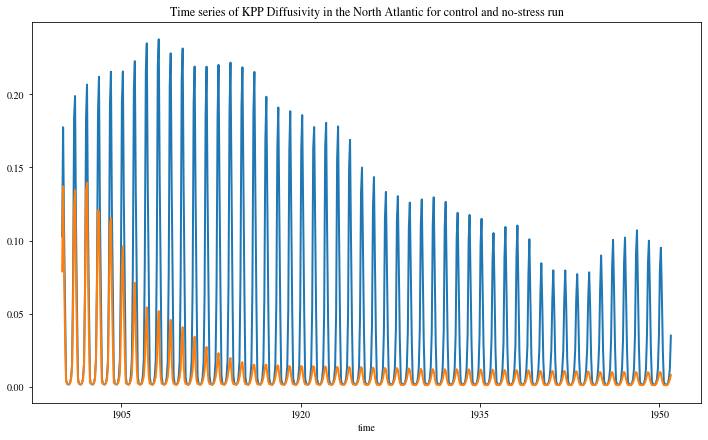

In [18]:
plt.figure(figsize = (12,7))
diff_cbt_con_avg.sel(st_ocean = slice(0,500)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'Control run')
diff_cbt_buo_avg.sel(st_ocean = slice(0,500)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'No stress run')
plt.title('Time series of KPP Diffusivity in the North Atlantic for control and no-stress run')
plt.show()

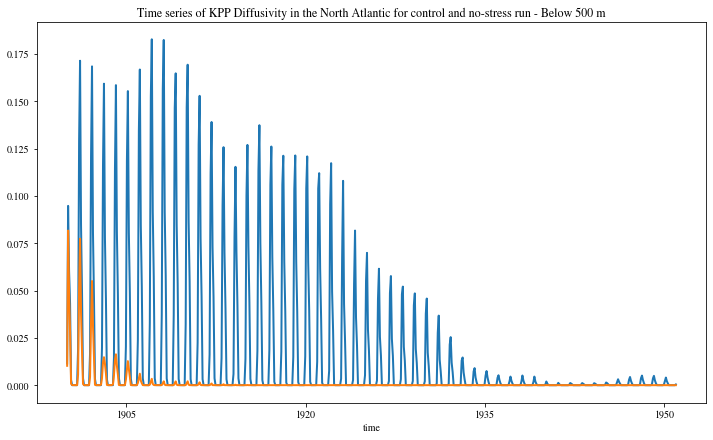

In [8]:
plt.figure(figsize = (12,7))
diff_cbt_con_avg.sel(st_ocean = slice(500,5000)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'Control run')
diff_cbt_buo_avg.sel(st_ocean = slice(500,5000)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'No stress run')
plt.title('Time series of KPP Diffusivity in the North Atlantic for control and no-stress run - Below 500 m')
plt.show()

### B. Pacific Ocean

In [9]:
area_t = cc.querying.getvar(expt=expt[0], variable='area_t', session=session, frequency='static', n=1).sel(
    xt_ocean = slice(-250,-100)).sel(yt_ocean = slice(10,70))
diff_cbt_con_avg = (diff_cbt_con*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
diff_cbt_buo_avg = (diff_cbt_buo*area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])

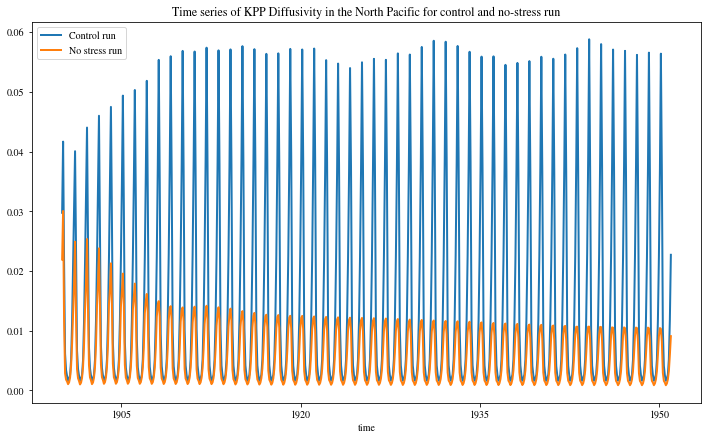

In [27]:
plt.figure(figsize = (12,7))
diff_cbt_con_avg.sel(st_ocean = slice(0,500)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'Control run')
diff_cbt_buo_avg.sel(st_ocean = slice(0,500)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'No stress run')
plt.title('Time series of KPP Diffusivity in the North Pacific for control and no-stress run')
plt.legend()
plt.show()

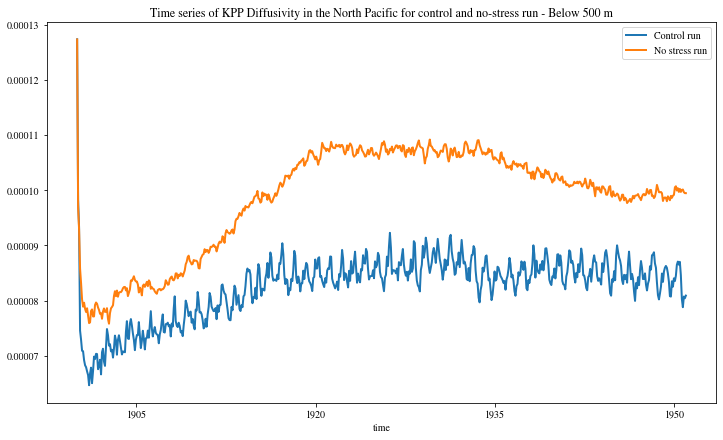

In [11]:
plt.figure(figsize = (12,7))
diff_cbt_con_avg.sel(st_ocean = slice(500,5000)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'Control run')
diff_cbt_buo_avg.sel(st_ocean = slice(500,5000)).mean('st_ocean').sel(time = slice('1900-01-01','1950-12-31')).plot(label = 'No stress run')
plt.title('Time series of KPP Diffusivity in the North Pacific for control and no-stress run - Below 500 m')
plt.legend()
plt.show()